In [1]:
!pip install keras-drop-block

  Preparing metadata (setup.py) ... done
  Created wheel for keras-drop-block: filename=keras_drop_block-0.7.0-py3-none-any.whl size=6253 sha256=7545bb03c5319b2d3f8e7916a04b9c1d01f05a0934cbae4538b375b02d48e18c
  Stored in directory: /root/.cache/pip/wheels/91/2a/81/77fa625804f1ff5bbe6b6f088e8153f9c4c9a379bf5061f151
Successfully built keras-drop-block


In [2]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
import tensorflow
import tensorflow.keras
from tensorflow.keras.applications import ResNet152, Xception,VGG16,EfficientNetB4
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
np.random.seed(123)
print("done")

done


In [3]:
lesion_type_dict = {'akiec': 'Actinic keratoses',
                    'bcc': 'Basal cell carcinoma',
                    'bkl': 'Benign keratosis-like lesions ',
                    'df': 'Dermatofibroma',
                    'nv': 'Melanocytic nevi',
                    'mel': 'Melanoma',
                    'vasc': 'Vascular lesions'}

base_skin_dir = os.path.join('..', 'input')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.groupby(['dx']).count()

,lesion_id,image_id,dx_type,age,sex,localization,path,cell_type,cell_type_idx
dx,,,,,,,,,
akiec,327,327,327,327,327,327,327,327,327
bcc,514,514,514,514,514,514,514,514,514
bkl,1099,1099,1099,1089,1099,1099,1099,1099,1099
df,115,115,115,115,115,115,115,115,115
mel,1113,1113,1113,1111,1113,1113,1113,1113,1113
nv,6705,6705,6705,6660,6705,6705,6705,6705,6705
vasc,142,142,142,142,142,142,142,142,142


In [4]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,100))))
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [5]:
from tensorflow.keras.utils import to_categorical
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.2,random_state=666)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)

In [6]:
#Reshaping the Images into 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [7]:
input_shape = (75, 100, 3)
num_classes = 7
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_learning_rate=0.00001)

#Data Generation
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

# ***VGG16 HeadModel_DO***

In [8]:
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization
from keras_drop_block import DropBlock2D
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
headModel = baseModel.output

headModel_DO = Dropout(0.5)(headModel)
headModel_DO = BatchNormalization()(headModel_DO)
headModel_DO = AveragePooling2D()(headModel_DO)
headModel_DO = Flatten(name="flatten")(headModel_DO)
headModel_DO = Dense(64, activation="relu")(headModel_DO)
headModel_DO = Dropout(0.5)(headModel_DO)
headModel_DO = Dense(7, activation="softmax")(headModel_DO)
model_DO = Model(inputs=baseModel.input, outputs=headModel_DO)

for layer in baseModel.layers:
    layer.trainable = False
    
model_DO.summary()

2022-09-20 05:29:36.420565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 05:29:36.533508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 05:29:36.534647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 05:29:36.537069: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
______________________________________________________________

In [9]:
model_DO.compile(loss="categorical_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])

H_DO = model_DO.fit(datagen.flow(x_train,y_train, batch_size=20),
                             epochs = 50, validation_data = (x_validate,y_validate), callbacks=[learning_rate_reduction])

2022-09-20 05:29:51.039965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-20 05:29:53.105921: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


361/361 [==============================] - 25s 47ms/step - loss: 1.1396 - accuracy: 0.6366 - val_loss: 1.0096 - val_accuracy: 0.6621
Epoch 2/50
361/361 [==============================] - 15s 41ms/step - loss: 0.9987 - accuracy: 0.6677 - val_loss: 0.9969 - val_accuracy: 0.6608
Epoch 3/50
361/361 [==============================] - 16s 45ms/step - loss: 0.9740 - accuracy: 0.6700 - val_loss: 0.9561 - val_accuracy: 0.6621
Epoch 4/50
361/361 [==============================] - 15s 42ms/step - loss: 0.9648 - accuracy: 0.6752 - val_loss: 0.9395 - val_accuracy: 0.6671
Epoch 5/50
361/361 [==============================] - 16s 43ms/step - loss: 0.9484 - accuracy: 0.6746 - val_loss: 0.9661 - val_accuracy: 0.6708
Epoch 6/50
361/361 [==============================] - 15s 42ms/step - loss: 0.9447 - accuracy: 0.6803 - val_loss: 0.9320 - val_accuracy: 0.6820
Epoch 7/50
361/361 [==============================] - 16s 43ms/step - loss: 0.9511 - accuracy: 0.6818 - val_loss: 0.9300 - val_accuracy: 0.6721
Epo

In [10]:
loss, accuracy = model_DO.evaluate(x_test, y_test, verbose=0)
predictions = model_DO.predict(x_test)
loss_v, accuracy_v = model_DO.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model_DO.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

2022-09-20 05:44:05.599580: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 648900000 exceeds 10% of free system memory.
2022-09-20 05:44:06.351310: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 648900000 exceeds 10% of free system memory.


Training: accuracy = 0.691540
Validation: accuracy = 0.680798
Test: accuracy = 0.685971


# ***VGG16 DB(3)***

In [11]:
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
headModel = baseModel.output

headModel_3 = DropBlock2D(block_size=3, keep_prob=0.5)(headModel)
headModel_3 = BatchNormalization()(headModel_3)
headModel_3 = AveragePooling2D()(headModel_3)
headModel_3 = Flatten(name="flatten")(headModel_3)
headModel_3 = Dense(64, activation="relu")(headModel_3)
headModel_3 = Dropout(0.5)(headModel_3)
headModel_3 = Dense(7, activation="softmax")(headModel_3)
model_3 = Model(inputs=baseModel.input, outputs=headModel_3)

for layer in baseModel.layers:
    layer.trainable = False
model_3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0   

In [12]:

model_3.compile(loss="categorical_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])
H3 = model_3.fit(datagen.flow(x_train,y_train, batch_size=20),
                             epochs = 50, validation_data = (x_validate,y_validate), callbacks=[learning_rate_reduction])


Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/backend.py:6089: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  warnings.warn('`tf.keras.backend.random_binomial` is deprecated, '


361/361 [==============================] - 16s 43ms/step - loss: 1.0578 - accuracy: 0.6566 - val_loss: 1.0331 - val_accuracy: 0.6646
Epoch 2/50
361/361 [==============================] - 16s 43ms/step - loss: 0.9485 - accuracy: 0.6714 - val_loss: 0.9196 - val_accuracy: 0.6920
Epoch 3/50
361/361 [==============================] - 15s 42ms/step - loss: 0.9297 - accuracy: 0.6836 - val_loss: 0.9645 - val_accuracy: 0.6708
Epoch 4/50
361/361 [==============================] - 15s 42ms/step - loss: 0.9148 - accuracy: 0.6835 - val_loss: 0.9377 - val_accuracy: 0.6783
Epoch 5/50
361/361 [==============================] - 15s 42ms/step - loss: 0.9028 - accuracy: 0.6850 - val_loss: 0.9270 - val_accuracy: 0.6771
Epoch 6/50
361/361 [==============================] - 16s 43ms/step - loss: 0.8928 - accuracy: 0.6879 - val_loss: 0.9141 - val_accuracy: 0.6920
Epoch 7/50
361/361 [==============================] - 15s 42ms/step - loss: 0.8784 - accuracy: 0.6890 - val_loss: 0.9752 - val_accuracy: 0.6783
Epo

In [13]:
loss, accuracy = model_3.evaluate(x_test, y_test, verbose=0)
predictions = model_3.predict(x_test)
loss_v, accuracy_v = model_3.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model_3.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))

print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

2022-09-20 05:58:18.365534: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 648900000 exceeds 10% of free system memory.
2022-09-20 05:58:19.100147: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 648900000 exceeds 10% of free system memory.


Training: accuracy = 0.697642
Validation: accuracy = 0.692020
Test: accuracy = 0.689965


# ***VGG16 DB(5)***

In [14]:

baseModel = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
headModel = baseModel.output
headModel_5 = DropBlock2D(block_size=5, keep_prob=0.5)(headModel)
headModel_5 = BatchNormalization()(headModel_5)
headModel_5 = AveragePooling2D()(headModel_5)
headModel_5 = Flatten(name="flatten")(headModel_5)
headModel_5 = Dense(64, activation="relu")(headModel_5)
headModel_5 = Dropout(0.5)(headModel_5)
headModel_5 = Dense(7, activation="softmax")(headModel_5)
model_5 = Model(inputs=baseModel.input, outputs=headModel_5)

model_5.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0   

In [15]:
model_5.compile(loss="categorical_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])
H5 = model_5.fit(datagen.flow(x_train,y_train, batch_size=20),
                             epochs = 50, validation_data = (x_validate,y_validate), callbacks=[learning_rate_reduction])


Epoch 1/50
361/361 [==============================] - 21s 53ms/step - loss: 1.1035 - accuracy: 0.6645 - val_loss: 1.1754 - val_accuracy: 0.6633
Epoch 2/50
361/361 [==============================] - 18s 51ms/step - loss: 1.0470 - accuracy: 0.6693 - val_loss: 1.0354 - val_accuracy: 0.6633
Epoch 3/50
361/361 [==============================] - 18s 51ms/step - loss: 1.0348 - accuracy: 0.6693 - val_loss: 1.0064 - val_accuracy: 0.6633
Epoch 4/50
361/361 [==============================] - 18s 50ms/step - loss: 1.0203 - accuracy: 0.6693 - val_loss: 0.9949 - val_accuracy: 0.6633
Epoch 5/50
361/361 [==============================] - 19s 51ms/step - loss: 1.0254 - accuracy: 0.6693 - val_loss: 0.9921 - val_accuracy: 0.6633
Epoch 6/50
361/361 [==============================] - 18s 50ms/step - loss: 1.0200 - accuracy: 0.6693 - val_loss: 1.0337 - val_accuracy: 0.6633
Epoch 7/50
361/361 [==============================] - 18s 49ms/step - loss: 1.0121 - accuracy: 0.6693 - val_loss: 1.0019 - val_accuracy:

In [16]:
loss, accuracy = model_5.evaluate(x_test, y_test, verbose=0)
predictions = model_5.predict(x_test)
loss_v, accuracy_v = model_5.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model_5.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

2022-09-20 06:14:04.718138: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 648900000 exceeds 10% of free system memory.


Training: accuracy = 0.669348
Validation: accuracy = 0.663342
Test: accuracy = 0.672491


# ***VGG16 DB(7)***

In [17]:
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
headModel = baseModel.output
headModel_7 = DropBlock2D(block_size=7, keep_prob=0.5)(headModel)
headModel_7 = BatchNormalization()(headModel_7)
headModel_7 = AveragePooling2D()(headModel_7)
headModel_7 = Flatten(name="flatten")(headModel_7)
headModel_7 = Dense(64, activation="relu")(headModel_7)
headModel_7 = Dropout(0.5)(headModel_7)
headModel_7 = Dense(7, activation="softmax")(headModel_7)
model_7 = Model(inputs=baseModel.input, outputs=headModel_7)
for layer in baseModel.layers:
    layer.trainable = False

model_7.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0   

In [18]:
model_7.compile(loss="categorical_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])
H7 = model_7.fit(datagen.flow(x_train,y_train, batch_size=20),
                             epochs = 50, validation_data = (x_validate,y_validate), callbacks=[learning_rate_reduction])

Epoch 1/50
361/361 [==============================] - 16s 43ms/step - loss: 1.0640 - accuracy: 0.6548 - val_loss: 0.9525 - val_accuracy: 0.6633
Epoch 2/50
361/361 [==============================] - 16s 44ms/step - loss: 0.9473 - accuracy: 0.6759 - val_loss: 0.9297 - val_accuracy: 0.6721
Epoch 3/50
361/361 [==============================] - 15s 41ms/step - loss: 0.9184 - accuracy: 0.6788 - val_loss: 0.9342 - val_accuracy: 0.6746
Epoch 4/50
361/361 [==============================] - 16s 43ms/step - loss: 0.9046 - accuracy: 0.6839 - val_loss: 0.9641 - val_accuracy: 0.6696
Epoch 5/50
361/361 [==============================] - 15s 42ms/step - loss: 0.9032 - accuracy: 0.6809 - val_loss: 0.9405 - val_accuracy: 0.6771
Epoch 6/50
361/361 [==============================] - 15s 41ms/step - loss: 0.8847 - accuracy: 0.6893 - val_loss: 0.9752 - val_accuracy: 0.6746
Epoch 7/50
361/361 [==============================] - 16s 44ms/step - loss: 0.8870 - accuracy: 0.6888 - val_loss: 0.9153 - val_accuracy:

In [19]:
loss, accuracy = model_7.evaluate(x_test, y_test, verbose=0)
predictions = model_7.predict(x_test)
loss_v, accuracy_v = model_7.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model_7.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

Training: accuracy = 0.702635
Validation: accuracy = 0.690773
Test: accuracy = 0.690464


# ***VGG16 SDO***

In [20]:
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization
from keras_drop_block import DropBlock2D
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
headModel = baseModel.output
headModel_SDO = SpatialDropout2D(0.5)(headModel)
headModel_SDO = BatchNormalization()(headModel_SDO)
headModel_SDO = AveragePooling2D()(headModel_SDO)
headModel_SDO = Flatten(name="flatten")(headModel_SDO)
headModel_SDO = Dense(64, activation="relu")(headModel_SDO)
headModel_SDO = Dropout(0.5)(headModel_SDO)
headModel_SDO = Dense(7, activation="softmax")(headModel_SDO)
model_SDO = Model(inputs=baseModel.input, outputs=headModel_SDO)

for layer in baseModel.layers:
    layer.trainable = False   

model_SDO.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0   

In [21]:
model_SDO.compile(loss="categorical_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])
HSDO = model_SDO.fit(datagen.flow(x_train,y_train, batch_size=20),
                             epochs = 50, validation_data = (x_validate,y_validate), callbacks=[learning_rate_reduction])

Epoch 1/50
361/361 [==============================] - 16s 44ms/step - loss: 1.1141 - accuracy: 0.6562 - val_loss: 0.9656 - val_accuracy: 0.6633
Epoch 2/50
361/361 [==============================] - 15s 41ms/step - loss: 1.0143 - accuracy: 0.6687 - val_loss: 0.9379 - val_accuracy: 0.6683
Epoch 3/50
361/361 [==============================] - 16s 45ms/step - loss: 0.9975 - accuracy: 0.6693 - val_loss: 0.9606 - val_accuracy: 0.6683
Epoch 4/50
361/361 [==============================] - 15s 41ms/step - loss: 0.9835 - accuracy: 0.6727 - val_loss: 0.9453 - val_accuracy: 0.6783
Epoch 5/50
361/361 [==============================] - 16s 43ms/step - loss: 0.9765 - accuracy: 0.6705 - val_loss: 0.9291 - val_accuracy: 0.6796
Epoch 6/50
361/361 [==============================] - 15s 41ms/step - loss: 0.9791 - accuracy: 0.6742 - val_loss: 0.9276 - val_accuracy: 0.6758
Epoch 7/50
361/361 [==============================] - 15s 43ms/step - loss: 0.9575 - accuracy: 0.6725 - val_loss: 0.9320 - val_accuracy:

In [22]:
loss, accuracy = model_SDO.evaluate(x_test, y_test, verbose=0)
predictions = model_SDO.predict(x_test)
loss_v, accuracy_v = model_SDO.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model_SDO.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

Training: accuracy = 0.693204
Validation: accuracy = 0.684539
Test: accuracy = 0.687968


# ***Plots***

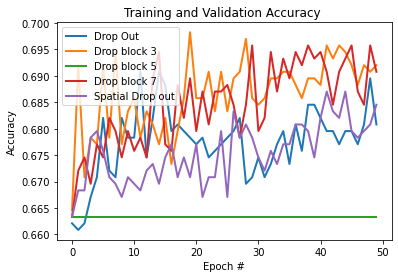

In [23]:
N = 50

plt.figure()
# plt.plot(np.arange(0, N), H.history["accuracy"], linewidth = 2, label="train_acc")
plt.plot(np.arange(0, N), H_DO.history["val_accuracy"], linewidth = 2, label="Drop Out")
plt.plot(np.arange(0, N), H3.history["val_accuracy"], linewidth = 2, label="Drop block 3")
plt.plot(np.arange(0, N), H5.history["val_accuracy"], linewidth = 2, label="Drop block 5")
plt.plot(np.arange(0, N), H7.history["val_accuracy"], linewidth = 2, label="Drop block 7")
plt.plot(np.arange(0, N), HSDO.history["val_accuracy"], linewidth = 2, label="Spatial Drop out")

plt.title("Training and Validation Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")